In [8]:
import gym
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import numpy as np

from keras.models import Sequential, clone_model
from keras.layers import Dense
from keras.optimizers import Adam

import time

## Plotting Function

In [9]:
def plot_res(values, title=''):
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## Deep Q Learning

In [21]:
def build_mlp_model(input_size, hidden_size,
                   output_size,loss='mse',optimizer=Adam()):
    model=Sequential()
    model.add(Dense(units=hidden_size,input_dim=input_size,
                    activation='relu'))
    model.add(Dense(units=hidden_size*2, activation='relu'))
    model.add(Dense(units=output_size, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)

    return model


#Implement DQN with keras
class DQN_keras():
    def __init__(self, build_func, input_size,
                hidden_size, output_size):
        self.model=build_func(input_size, hidden_size, output_size)
        # add target network
        self.target_nn = clone_model(self.model)
        self.target_nn.set_weights(self.model.get_weights())

    def update(self, state, y):
        """Update the weighs of the network
           given a training sample
        args:
          state: the input to predict
          y: the label
        """
        self.model.fit(np.array([state]), np.array([y]), verbose=0)

    def target_update(self):
        self.target_nn.set_weights(self.model.get_weights())

    def predict(self, state):
        """Compute Q values for all actions of one state
           of a state
        """
        return self.model.predict(np.array([state]))[0]

    # def target_predict(self, state):
    #     return self.target_nn.predict(np.array([state]))[0]


    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]

            states = np.array(states)
            actions = np.array(actions)
            next_states = np.array(next_states)
            rewards = np.array(rewards)
            is_dones = np.array(is_dones)

            is_dones_indices = np.where(is_dones==True)[0]

            all_q_values = self.model.predict(states) # predicted q_values of all states

            #Update q values
            target_q_values_next = self.target_nn.predict(next_states)
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*np.max(target_q_values_next, axis=1)
            # if is done
            all_q_values[is_dones_indices, actions[is_dones]]=rewards[is_dones_indices]

            self.model.fit(states, all_q_values, verbose=0)

In [10]:
def epsilon_greedy(model, epsilon, env, state):
    if random.random() < epsilon:
        return env.action_space.sample()  # random action
    else:
        q_values = model.predict(state)
        return np.argmax(q_values)  # q-optimal action

In [27]:
def q_learning_keras(env, model, episodes, gamma=0.9,
                    epsilon=0.3, eps_decay=0.99,
                    replay=False, replay_size=20, n_update=10,
                     title='DQN', verbose=True):
    """Deep Q Learning Algorithm using DQN"""
    final=[] #to store total rewards of every game
    memory=[] #to store replay experience

    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if episode % n_update == 0:
            model.target_update()
        # reset state
        state = env.reset()
        #print("type of state: ", type(state))
        #print("shape of state: ", state.shape)
        #print("state: ", state)
        #print(np.array([state]))
        done = False
        total=0
        total_replay_time=0
        while not done:
            # epsilon-greedy
            action = epsilon_greedy(model, epsilon, env, state)

            #Take action and add reward to total
            next_state, reward, done, _ = env.step(action)

            #Update total rewards memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state)
            q_values_list = q_values.tolist()

            if done:
                if not replay:
                    q_values_list[action]=reward
                    #Update network weights using q_values_list as label
                    model.update(state, q_values)
                    break


            if replay:
                t0 = time.time()
                #Update network weights using replay buffer
                #replay in every episode
                model.replay(memory, replay_size, gamma)
                t1 = time.time()
                total_replay_time+=(t1-t0)

            else:
                #Update network weights using the last step
                q_values_next = model.predict(next_state)
                q_values[action]=reward+gamma*np.max(q_values_next)
                model.update(state, q_values)#use new q_values as the label

            state = next_state



        #Update epsilon
        epsilon = max(epsilon*eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        sum_total_replay_time +=total_replay_time

        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("replay time of this episode: ", total_replay_time)
                print("Average replay time:", sum_total_replay_time/episode_i)


    return final

### using original replay function

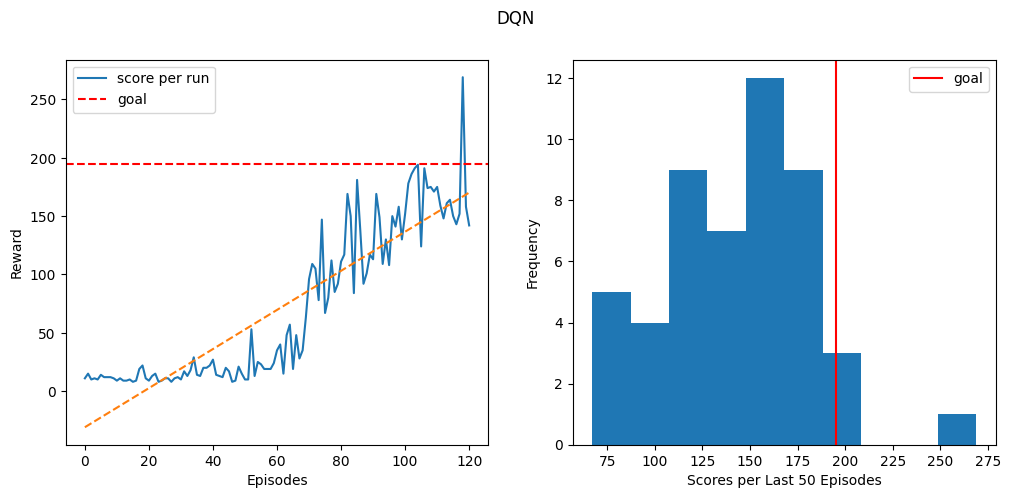

episode: 121, total reward: 142.0
replay time of this episode:  27.976928234100342
Average replay time: 13.787896091287786
1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: ignored

In [28]:
env = gym.envs.make("CartPole-v1")


n_state = env.observation_space.shape[0]
#Number of states
n_action = env.action_space.n
#Number of actions
episodes = 150
n_hidden = 50

dqn_keras = DQN_keras(build_mlp_model, n_state, n_hidden, n_action)
rewards_episodes = q_learning_keras(env, dqn_keras, episodes, replay=True)

### using new replay function

In [22]:
def epsilon_greedy(model, epsilon, env, state):
    if random.random() < epsilon:
        return env.action_space.sample()  # random action
    else:
        q_values = model.predict(np.array([state]))[0]
        return np.argmax(q_values)  # q-optimal action

def test_dqn(env, n_games, model, eps=0.05, render=False, sleep_time=0.01):
    scores = []
    for i in range(n_games):
        obs = env.reset()
        print(obs)
        score = 0
        done = False
        while not done:
            q_values = model.predict(np.array([obs]))[0]
            action = epsilon_greedy(model, eps, env, obs)
            obs, reward, done, info = env.step(action)
            score += reward
            print
            if render:
                env.render()
                time.sleep(sleep_time)
        scores.append(score)
    return scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
scores = test_dqn(env, 5, dqn_keras.model, env, eps=0.01)

NameError: ignored

In [4]:
from keras.models import load_model
from google.colab import drive

drive.mount('/content/drive')
dqn_model = load_model('/content/drive/My Drive/UChicago_Project/RL/saved_ddqn_model0817.h5')

Mounted at /content/drive


In [23]:
env = gym.envs.make("CartPole-v1")
scores = test_dqn(env, 5, dqn_model, eps=0.01)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[-0.03601561  0.01210182  0.01770809 -0.03812688]
1/1 [==============================] - 0s 20ms/step
[-0.01239351  0.04696998 -0.0027428  -0.0234964 ]
1/1 [==============================] - 0s 22ms/step
[-0.01053586  0.03817862  0.0059498   0.02964052]
1/1 [==============================] - 0s 21ms/step
[ 0.03607162 -0.00767409  0.04178202 -0.01645593]
1/1 [==============================] - 0s 27ms/step
[ 0.0150953   0.03890563  0.02714757 -0.00514814]
1/1 [==============================] - 0s 23ms/step


In [24]:
nn_mean,nn_std,nn_min,nn_max, nn_median = np.mean(scores), np.std(scores), \
                               np.min(scores), np.max(scores), np.median(scores)
nn_mean,nn_std,nn_min,nn_max, nn_median

(168.0, 21.963606261267753, 143.0, 203.0, 168.0)

## Save Model

In [30]:
from google.colab import drive
drive.mount('/content/drive')

dqn_keras.model.save('/content/drive/My Drive/UChicago_Project/RL/saved_ddqn_model0817.h5')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
dqn_keras.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5,552
Trainable params: 5,552
Non-trainable params: 0
_________________________________________________________________
